In [1]:
import torch
import torchvision
from torch import nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import ConcatDataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from time import time
from statistics import mean

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
tranform_m = transforms.Compose([
    transforms.Resize((224,224)), 
    transforms.RandomHorizontalFlip(p=1),
    transforms.RandomAffine(degrees=15),
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

tranform_n = transforms.Compose([
    transforms.Resize((224,224)), 
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = torchvision.datasets.ImageFolder(root='/kaggle/input/indian-food-16/Train', transform=tranform_n)
test_dataset = torchvision.datasets.ImageFolder(root='/kaggle/input/indian-food-16/Test', transform=tranform_n)
valid_dataset = torchvision.datasets.ImageFolder(root='/kaggle/input/indian-food-16/Validate', transform=tranform_n)
train_dataset_t = torchvision.datasets.ImageFolder(root='/kaggle/input/indian-food-16/Train', transform=tranform_m)
test_dataset_t = torchvision.datasets.ImageFolder(root='/kaggle/input/indian-food-16/Test', transform=tranform_m)
valid_dataset_t = torchvision.datasets.ImageFolder(root='/kaggle/input/indian-food-16/Validate', transform=tranform_m)
batch_size = 32
combi_train = ConcatDataset([train_dataset, train_dataset_t])
combi_valid = ConcatDataset([valid_dataset, valid_dataset_t])
combi_test = ConcatDataset([test_dataset, test_dataset_t])
train_dataloader = DataLoader(combi_train, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(combi_valid, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(combi_test, batch_size=batch_size, shuffle=False)

print('Train DataSet len:',len(combi_train))
print('Valid DataSet len:',len(combi_valid))
print('Test DataSet len:',len(combi_test))
print('Total DataSet Classes:',len(test_dataset.classes))

Train DataSet len: 9086
Valid DataSet len: 1328
Test DataSet len: 2588
Total DataSet Classes: 14


In [3]:
from torch import cuda

train_on_gpu = cuda.is_available()
print(f'Train on gpu: {train_on_gpu}')

# Number of gpus
if train_on_gpu:
    gpu_count = cuda.device_count()
    print(f'{gpu_count} gpus detected.')
    if gpu_count > 1:
        multi_gpu = True
    else:
        multi_gpu = False


Train on gpu: True
2 gpus detected.


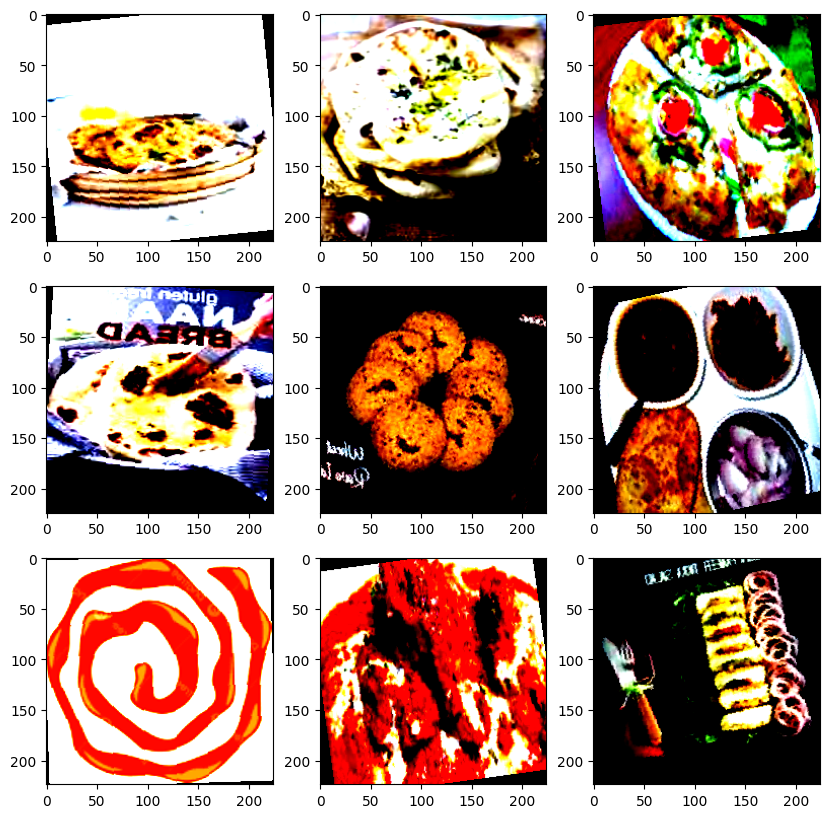

In [4]:
image = next(iter(train_dataloader))

fig, axes = plt.subplots(3, 3, figsize=(10, 10))

# Iterate over the subplots and plot an image in each one
for i in range(9):
    axes[i // 3, i % 3].imshow(image[0][i].permute(1,2,0))
    

In [5]:
model = torchvision.models.vgg16(pretrained=True)
model

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:01<00:00, 289MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [6]:
for param in model.parameters():
    param.requires_grad = False

In [7]:
n_inputs = model.classifier[6].in_features

# Add on classifier
model.classifier[6] = nn.Sequential(
    nn.Linear(n_inputs, 256), nn.ReLU(), nn.Dropout(0.4),
    nn.Linear(256, 14), nn.LogSoftmax(dim=1))

model.classifier


Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Sequential(
    (0): Linear(in_features=4096, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4, inplace=False)
    (3): Linear(in_features=256, out_features=14, bias=True)
    (4): LogSoftmax(dim=1)
  )
)

In [8]:
total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

135,312,974 total parameters.
1,052,430 training parameters.


In [9]:
if train_on_gpu:
    model = model.to('cuda')
    print("On CUDA")
else:
    print("On CPU")

if multi_gpu:
    model = nn.DataParallel(model)
    print("Multiple GPUs")
else:
    print("Single or No GPU")

On CUDA
Multiple GPUs


In [10]:
!pip install torch-summary
from torchsummary import summary
summary(model, input_size=(3, 224, 224), batch_size=32, device='cuda')

Layer (type:depth-idx)                   Param #
├─VGG: 1-1                               --
|    └─Sequential: 2-1                   --
|    |    └─Conv2d: 3-1                  (1,792)
|    |    └─ReLU: 3-2                    --
|    |    └─Conv2d: 3-3                  (36,928)
|    |    └─ReLU: 3-4                    --
|    |    └─MaxPool2d: 3-5               --
|    |    └─Conv2d: 3-6                  (73,856)
|    |    └─ReLU: 3-7                    --
|    |    └─Conv2d: 3-8                  (147,584)
|    |    └─ReLU: 3-9                    --
|    |    └─MaxPool2d: 3-10              --
|    |    └─Conv2d: 3-11                 (295,168)
|    |    └─ReLU: 3-12                   --
|    |    └─Conv2d: 3-13                 (590,080)
|    |    └─ReLU: 3-14                   --
|    |    └─Conv2d: 3-15                 (590,080)
|    |    └─ReLU: 3-16                   --
|    |    └─MaxPool2d: 3-17              --
|    |    └─Conv2d: 3-18                 (1,180,160)
|    |    └─ReLU:

Layer (type:depth-idx)                   Param #
├─VGG: 1-1                               --
|    └─Sequential: 2-1                   --
|    |    └─Conv2d: 3-1                  (1,792)
|    |    └─ReLU: 3-2                    --
|    |    └─Conv2d: 3-3                  (36,928)
|    |    └─ReLU: 3-4                    --
|    |    └─MaxPool2d: 3-5               --
|    |    └─Conv2d: 3-6                  (73,856)
|    |    └─ReLU: 3-7                    --
|    |    └─Conv2d: 3-8                  (147,584)
|    |    └─ReLU: 3-9                    --
|    |    └─MaxPool2d: 3-10              --
|    |    └─Conv2d: 3-11                 (295,168)
|    |    └─ReLU: 3-12                   --
|    |    └─Conv2d: 3-13                 (590,080)
|    |    └─ReLU: 3-14                   --
|    |    └─Conv2d: 3-15                 (590,080)
|    |    └─ReLU: 3-16                   --
|    |    └─MaxPool2d: 3-17              --
|    |    └─Conv2d: 3-18                 (1,180,160)
|    |    └─ReLU:

In [11]:
from torchvision import models
def get_pretrained_model(model_name):
    """Retrieve a pre-trained model from torchvision

    Params
    -------
        model_name (str): name of the model (currently only accepts vgg16 and resnet50)

    Return
    --------
        model (PyTorch model): cnn

    """

    if model_name == 'vgg16':
        model = models.vgg16(pretrained=True)

        # Freeze early layers
        for param in model.parameters():
            param.requires_grad = False
        n_inputs = model.classifier[6].in_features

        # Add on classifier
        model.classifier[6] = nn.Sequential(
            nn.Linear(n_inputs, 256), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(256, 14), nn.LogSoftmax(dim=1))

    elif model_name == 'resnet50':
        model = models.resnet50(pretrained=True)

        for param in model.parameters():
            param.requires_grad = False

        n_inputs = model.fc.in_features
        model.fc = nn.Sequential(
            nn.Linear(n_inputs, 256), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(256, 14), nn.LogSoftmax(dim=1))

    # Move to gpu and parallelize
    if train_on_gpu:
        model = model.to('cuda')

    if multi_gpu:
        model = nn.DataParallel(model)

    return model

In [12]:

model = get_pretrained_model('resnet50')
if multi_gpu:
    summary(
        model.module,
        input_size=(3, 224, 224),
        batch_size=batch_size,
        device='cuda')
else:
    summary(
        model, input_size=(3, 224, 224), batch_size=32, device='cuda')

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 83.1MB/s]


Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            (9,408)
├─BatchNorm2d: 1-2                       (128)
├─ReLU: 1-3                              --
├─MaxPool2d: 1-4                         --
├─Sequential: 1-5                        --
|    └─Bottleneck: 2-1                   --
|    |    └─Conv2d: 3-1                  (4,096)
|    |    └─BatchNorm2d: 3-2             (128)
|    |    └─Conv2d: 3-3                  (36,864)
|    |    └─BatchNorm2d: 3-4             (128)
|    |    └─Conv2d: 3-5                  (16,384)
|    |    └─BatchNorm2d: 3-6             (512)
|    |    └─ReLU: 3-7                    --
|    |    └─Sequential: 3-8              (16,896)
|    └─Bottleneck: 2-2                   --
|    |    └─Conv2d: 3-9                  (16,384)
|    |    └─BatchNorm2d: 3-10            (128)
|    |    └─Conv2d: 3-11                 (36,864)
|    |    └─BatchNorm2d: 3-12            (128)
|    |    └─Conv2d: 3-13                 (16,384)
|    | 

In [13]:
model.class_to_idx = train_dataset.class_to_idx
model.idx_to_class = {
    idx: class_
    for class_, idx in model.class_to_idx.items()
}

list(model.idx_to_class.items())

[(0, 'AlooParatha'),
 (1, 'Biryani'),
 (2, 'ButterChicken'),
 (3, 'CholeBhature'),
 (4, 'DalMakhani'),
 (5, 'Dosa'),
 (6, 'GulabJamuninbowl'),
 (7, 'Idli'),
 (8, 'Jalebionplate'),
 (9, 'Naan'),
 (10, 'PaneerTikka'),
 (11, 'PaniPuri'),
 (12, 'Samosas'),
 (13, 'VadaPav')]

In [14]:
from torch import optim
# Loss and optimizer
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters())

In [15]:
for p in optimizer.param_groups[0]['params']:
    if p.requires_grad:
        print(p.shape)


torch.Size([256, 2048])
torch.Size([256])
torch.Size([14, 256])
torch.Size([14])


In [16]:
from timeit import default_timer as timer
import numpy as np
import pandas as pd

def train(model,
          criterion,
          optimizer,
          train_loader,
          valid_loader,
          save_file_name,
          max_epochs_stop=3,
          n_epochs=50,
          print_every=2):
    """Train a PyTorch Model

    Params
    --------
        model (PyTorch model): cnn to train
        criterion (PyTorch loss): objective to minimize
        optimizer (PyTorch optimizier): optimizer to compute gradients of model parameters
        train_loader (PyTorch dataloader): training dataloader to iterate through
        valid_loader (PyTorch dataloader): validation dataloader used for early stopping
        save_file_name (str ending in '.pt'): file path to save the model state dict
        max_epochs_stop (int): maximum number of epochs with no improvement in validation loss for early stopping
        n_epochs (int): maximum number of training epochs
        print_every (int): frequency of epochs to print training stats

    Returns
    --------
        model (PyTorch model): trained cnn with best weights
        history (DataFrame): history of train and validation loss and accuracy
    """

    # Early stopping intialization
    epochs_no_improve = 0
    valid_loss_min = np.Inf

    valid_max_acc = 0
    history = []

    # Number of epochs already trained (if using loaded in model weights)
    try:
        print(f'Model has been trained for: {model.epochs} epochs.\n')
    except:
        model.epochs = 0
        print(f'Starting Training from Scratch.\n')

    overall_start = timer()

    # Main loop
    for epoch in range(n_epochs):

        # keep track of training and validation loss each epoch
        train_loss = 0.0
        valid_loss = 0.0

        train_acc = 0
        valid_acc = 0

        # Set to training
        model.train()
        start = timer()

        # Training loop
        for ii, (data, target) in enumerate(train_loader):
            # Tensors to gpu
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()

            # Clear gradients
            optimizer.zero_grad()
            # Predicted outputs are log probabilities
            output = model(data)

            # Loss and backpropagation of gradients
            loss = criterion(output, target)
            loss.backward()

            # Update the parameters
            optimizer.step()

            # Track train loss by multiplying average loss by number of examples in batch
            train_loss += loss.item() * data.size(0)

            # Calculate accuracy by finding max log probability
            _, pred = torch.max(output, dim=1)
            correct_tensor = pred.eq(target.data.view_as(pred))
            # Need to convert correct tensor from int to float to average
            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
            # Multiply average accuracy times the number of examples in batch
            train_acc += accuracy.item() * data.size(0)

            # Track training progress
            print(
                f'Epoch: {epoch}\t{100 * (ii + 1) / len(train_loader):.2f}% complete. {timer() - start:.2f} seconds elapsed in epoch.',
                end='\r')

        # After training loops ends, start validation
        else:
            model.epochs += 1

            # Don't need to keep track of gradients
            with torch.no_grad():
                # Set to evaluation mode
                model.eval()

                # Validation loop
                for data, target in valid_loader:
                    # Tensors to gpu
                    if train_on_gpu:
                        data, target = data.cuda(), target.cuda()

                    # Forward pass
                    output = model(data)

                    # Validation loss
                    loss = criterion(output, target)
                    # Multiply average loss times the number of examples in batch
                    valid_loss += loss.item() * data.size(0)

                    # Calculate validation accuracy
                    _, pred = torch.max(output, dim=1)
                    correct_tensor = pred.eq(target.data.view_as(pred))
                    accuracy = torch.mean(
                        correct_tensor.type(torch.FloatTensor))
                    # Multiply average accuracy times the number of examples
                    valid_acc += accuracy.item() * data.size(0)

                # Calculate average losses
                train_loss = train_loss / len(train_loader.dataset)
                valid_loss = valid_loss / len(valid_loader.dataset)

                # Calculate average accuracy
                train_acc = train_acc / len(train_loader.dataset)
                valid_acc = valid_acc / len(valid_loader.dataset)

                history.append([train_loss, valid_loss, train_acc, valid_acc])

                # Print training and validation results
                if (epoch + 1) % print_every == 0:
                    print(
                        f'\nEpoch: {epoch} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {valid_loss:.4f}'
                    )
                    print(
                        f'\t\tTraining Accuracy: {100 * train_acc:.2f}%\t Validation Accuracy: {100 * valid_acc:.2f}%'
                    )

                # Save the model if validation loss decreases
                if valid_loss < valid_loss_min:
                    # Save model
                    torch.save(model.state_dict(), save_file_name)
                    # Track improvement
                    epochs_no_improve = 0
                    valid_loss_min = valid_loss
                    valid_best_acc = valid_acc
                    best_epoch = epoch

                # Otherwise increment count of epochs with no improvement
                else:
                    epochs_no_improve += 1
                    # Trigger early stopping
                    if epochs_no_improve >= max_epochs_stop:
                        print(
                            f'\nEarly Stopping! Total epochs: {epoch}. Best epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
                        )
                        total_time = timer() - overall_start
                        print(
                            f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.'
                        )

                        # Load the best state dict
                        model.load_state_dict(torch.load(save_file_name))
                        # Attach the optimizer
                        model.optimizer = optimizer

                        # Format history
                        history = pd.DataFrame(
                            history,
                            columns=[
                                'train_loss', 'valid_loss', 'train_acc',
                                'valid_acc'
                            ])
                        return model, history

    # Attach the optimizer
    model.optimizer = optimizer
    # Record overall time and print out stats
    total_time = timer() - overall_start
    print(
        f'\nBest epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
    )
    print(
        f'{total_time:.2f} total seconds elapsed. {total_time / (epoch):.2f} seconds per epoch.'
    )
    # Format history
    history = pd.DataFrame(
        history,
        columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])
    return model, history

In [17]:
model, history = train(
    model,
    criterion,
    optimizer,
    train_dataloader,
    valid_dataloader,
    save_file_name='/kaggle/working/resnet50-pretrain.pt',
    max_epochs_stop=5,
    n_epochs=30,
    print_every=2)


Starting Training from Scratch.

Epoch: 1	100.00% complete. 44.78 seconds elapsed in epoch.
Epoch: 1 	Training Loss: 1.0269 	Validation Loss: 0.8409
		Training Accuracy: 67.59%	 Validation Accuracy: 73.80%
Epoch: 3	100.00% complete. 44.66 seconds elapsed in epoch.
Epoch: 3 	Training Loss: 0.8672 	Validation Loss: 0.7529
		Training Accuracy: 72.21%	 Validation Accuracy: 76.81%
Epoch: 5	100.00% complete. 44.98 seconds elapsed in epoch.
Epoch: 5 	Training Loss: 0.8030 	Validation Loss: 0.7396
		Training Accuracy: 74.42%	 Validation Accuracy: 76.96%
Epoch: 7	100.00% complete. 45.81 seconds elapsed in epoch.
Epoch: 7 	Training Loss: 0.7508 	Validation Loss: 0.7301
		Training Accuracy: 75.45%	 Validation Accuracy: 77.94%
Epoch: 9	100.00% complete. 44.74 seconds elapsed in epoch.
Epoch: 9 	Training Loss: 0.7242 	Validation Loss: 0.6922
		Training Accuracy: 76.10%	 Validation Accuracy: 78.54%
Epoch: 11	100.00% complete. 45.51 seconds elapsed in epoch.
Epoch: 11 	Training Loss: 0.6615 	Validati

Text(0.5, 1.0, 'Training and Validation Losses')

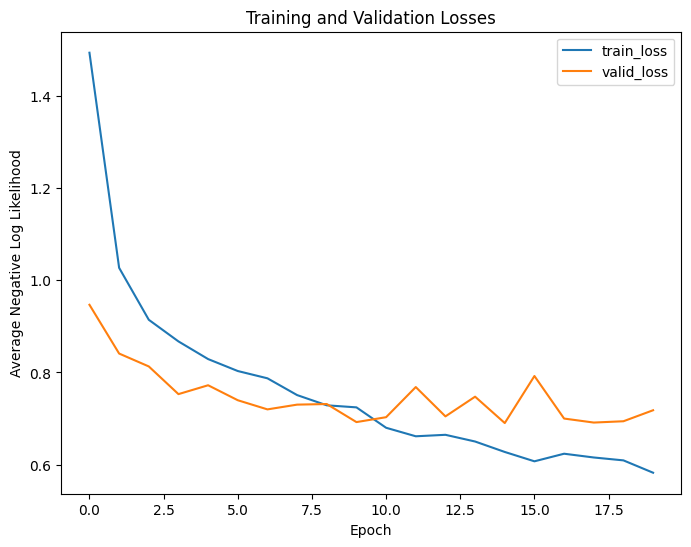

In [18]:
plt.figure(figsize=(8, 6))
for c in ['train_loss', 'valid_loss']:
    plt.plot(
        history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Negative Log Likelihood')
plt.title('Training and Validation Losses')

Text(0.5, 1.0, 'Training and Validation Accuracy')

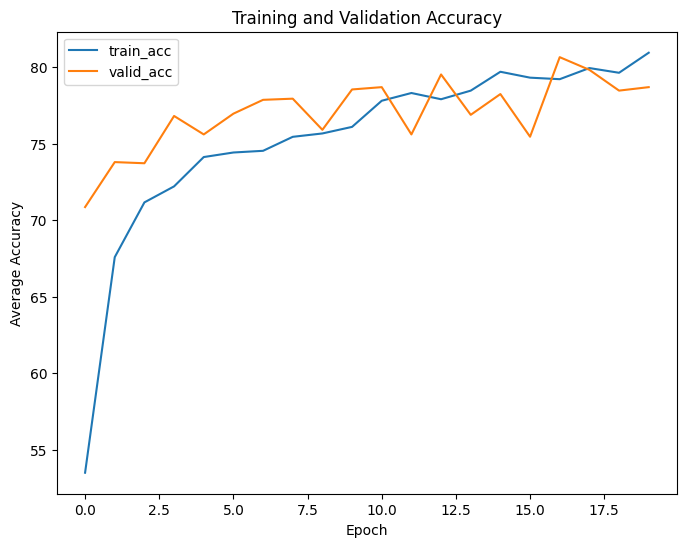

In [19]:
plt.figure(figsize=(8, 6))
for c in ['train_acc', 'valid_acc']:
    plt.plot(
        100 * history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Accuracy')
plt.title('Training and Validation Accuracy')

In [20]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_dataloader:
        images = images.to(device='cuda')
        labels = labels.to(device='cuda') 
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print('Accuracy of the Model on the {} Test Images: {}%'.format(len(test_dataset), 100*correct /total))


Accuracy of the Model on the 1294 Test Images: 77.08655332302936%


In [21]:
from PIL import Image
def process_image(image_path):
    """Process an image path into a PyTorch tensor"""

    image = Image.open(image_path)
    # Resize
    img = image.resize((256, 256))

    # Center crop
    width = 256
    height = 256
    new_width = 224
    new_height = 224

    left = (width - new_width) / 2
    top = (height - new_height) / 2
    right = (width + new_width) / 2
    bottom = (height + new_height) / 2
    img = img.crop((left, top, right, bottom))

    # Convert to numpy, transpose color dimension and normalize
    img = np.array(img).transpose((2, 0, 1)) / 256

    # Standardization
    means = np.array([0.485, 0.456, 0.406]).reshape((3, 1, 1))
    stds = np.array([0.229, 0.224, 0.225]).reshape((3, 1, 1))

    img = img - means
    img = img / stds

    img_tensor = torch.Tensor(img)

    return img_tensor

In [22]:
def predict(image_path, model, topk=5):
    """Make a prediction for an image using a trained model

    Params
    --------
        image_path (str): filename of the image
        model (PyTorch model): trained model for inference
        topk (int): number of top predictions to return

    Returns

    """

    # Convert to pytorch tensor
    img_tensor = process_image(image_path)

    # Resize
    if train_on_gpu:
        img_tensor = img_tensor.view(1, 3, 224, 224).cuda()
    else:
        img_tensor = img_tensor.view(1, 3, 224, 224)

    # Set to evaluation
    with torch.no_grad():
        model.eval()
        # Model outputs log probabilities
        out = model(img_tensor)
        ps = torch.exp(out)

        # Find the topk predictions
        topk, topclass = ps.topk(topk, dim=1)

        # Extract the actual classes and probabilities
        top_classes = [
            model.idx_to_class[class_] for class_ in topclass.cpu().numpy()[0]
        ]
        top_p = topk.cpu().numpy()[0]

        return img_tensor.cpu().squeeze(), top_p, top_classes

In [23]:
predict('/kaggle/input/indian-food-16/Test/Biryani/Biryani103.jpg', model, 5)  # Biryani

(tensor([[[ 1.7883,  1.7542,  1.7031,  ..., -0.9750, -0.9239, -0.8897],
          [ 1.1401,  1.1060,  1.0378,  ..., -1.0262, -1.0091, -0.9580],
          [ 0.4749,  0.5943,  0.6796,  ..., -0.9409, -0.8727, -0.8215],
          ...,
          [ 1.2766,  1.4642,  1.6860,  ..., -0.8727, -0.7874, -0.6680],
          [ 0.9525,  1.2596,  1.5495,  ..., -0.8727, -0.7874, -0.6680],
          [ 0.5261,  0.9184,  1.2425,  ..., -0.8727, -0.7874, -0.6680]],
 
         [[ 1.3997,  1.3997,  1.2602,  ..., -0.7627, -0.7278, -0.6581],
          [ 0.6150,  0.5975,  0.4929,  ..., -0.8150, -0.7976, -0.7453],
          [-0.1523, -0.0128,  0.0744,  ..., -0.7104, -0.6581, -0.6057],
          ...,
          [-0.0477,  0.1790,  0.4580,  ..., -0.7104, -0.6232, -0.5011],
          [-0.3790, -0.0477,  0.3011,  ..., -0.7104, -0.6232, -0.5011],
          [-0.8499, -0.4139, -0.0477,  ..., -0.7104, -0.6232, -0.5011]],
 
         [[ 0.6608,  0.6435,  0.5046,  ..., -1.1447, -1.1447, -1.1447],
          [-0.1725, -0.1899,